In [ ]:
#### DATA ANALYSIS NOTEBOOK
''' 
This project analyses how the motivations and conlcusion of acdemic computer science abstracts relate to AI risks and whether this relationship is different for papers with authors with Big Tech affiliations.
Computer Science papers with authors that have Big Tech affiliations are reffered to as 'Collaboration papers' (Papers produced by Industry and academia together). In the data they are called 'company_abstracts'

Furthermore, this project analyses how the AI risks that are disucssed in the movitation and conlusions section of academic research have changed after the intrudction of ChatGPT.

For a full written explanation of the methodology, see the related paper.
'''

In [15]:
import re
import pickle
import numpy as np
import gensim
print(gensim.__version__)
import os
from scipy.spatial.distance import cosine
import sys
import datetime
import matplotlib.pyplot as plt
import statistics
from mlxtend.evaluate import permutation_test
from sklearn.metrics.pairwise import cosine_similarity
import random
os.getcwd()

3.8.3


In [16]:
# Load 'company_abstracts'
with open('company_abstracts.pkl', 'rb') as f:
    company_abstracts = pickle.load(f)

# Load 'academic_abstracts'
with open('academic_abstracts.pkl', 'rb') as f:
    academic_abstracts = pickle.load(f)

In [46]:
print(len(academic_abstracts))
print(len(company_abstracts) + len(academic_abstracts))

69918
95148


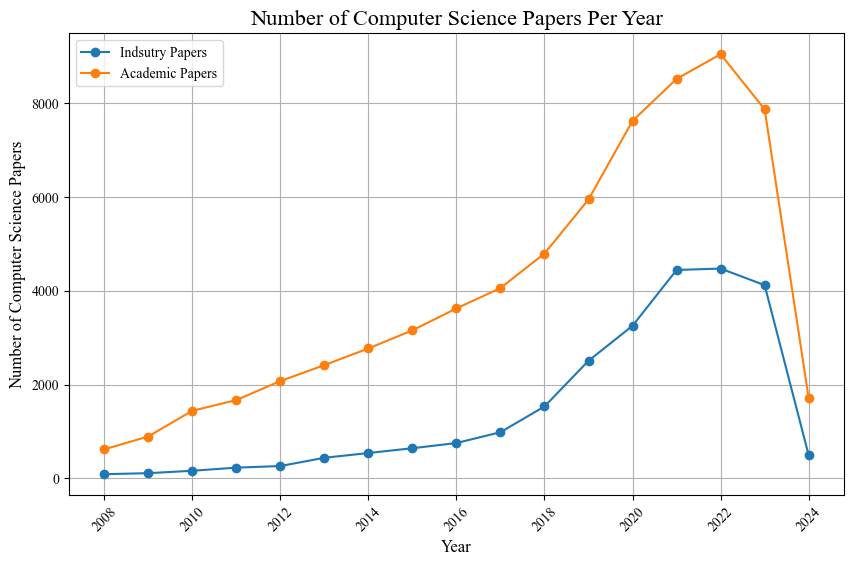

In [18]:
import matplotlib.pyplot as plt

#data for company abstracts per year and academic abstracts per year
years = list(range(2008, 2025))
academic_abstracts_year = []
company_abstracts_year = []
for year in years:
    academic_abstracts_year.append(len([i for i in academic_abstracts if i['publication_year_OA'] == year]))
    company_abstracts_year.append(len([i for i in company_abstracts if i['publication_year_OA'] == year]))

font_properties = {'family': 'times new roman', 'size': 10}

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, company_abstracts_year, marker='o', label='Collaboration Papers')
plt.plot(years, academic_abstracts_year, marker='o', label='Academic Papers')
plt.ylabel('Number of Computer Science Papers', fontsize=12, fontname='Times New Roman')
plt.xlabel('Year', fontsize=12, fontname='Times New Roman')
plt.title('Number of Computer Science Papers Per Year', fontsize=16, fontname='Times New Roman')
plt.xticks(range(2008, 2025, 2), rotation=45, fontsize=10, fontname='Times New Roman')
plt.yticks(fontsize=10, fontname='Times New Roman')
plt.legend(prop=font_properties)
plt.grid(True)
plt.show()


In [19]:
#create a company_abstracts data set with only papers published before 2022
company_abstracts_before_2022 = [i for i in company_abstracts if i["publication_year_OA"] < 2022]
company_abstracts_during_after_2022 = [i for i in company_abstracts if i["publication_year_OA"] >= 2022]

#check the length of the two data sets
print(len(company_abstracts_before_2022))
print(len(company_abstracts_during_after_2022))

academic_abstracts_before_2022 = [i for i in academic_abstracts if i["publication_year_OA"] < 2022]
academic_abstracts_during_after_2022 = [i for i in academic_abstracts if i["publication_year_OA"] >= 2022]

#check the length of the two data sets
print(len(academic_abstracts_before_2022))
print(len(academic_abstracts_during_after_2022))

11697
13533
42766
27152


In [20]:
#function to get a list of tokenized abstracts from the data.

def get_abstract_list(data):
    abstract_list = []
    for i in data:
        abstract = i["abstract_cleaned"]
        abstract_list.append(abstract)
    return abstract_list

#create the lists 

company_abstracts_before_2022_list = get_abstract_list(company_abstracts_before_2022)

company_abstracts_during_after_2022_list = get_abstract_list(company_abstracts_during_after_2022)

academic_abstracts_before_2022_list = get_abstract_list(academic_abstracts_before_2022)

academic_abstracts_during_after_2022_list = get_abstract_list(academic_abstracts_during_after_2022)

In [23]:
#function to train the word2vec model. SG = 0 is CBOW, SG = 1 is skip-gram model. Change SG to 1 here to change all analyses to the skip-gram model.
def train_model(data, model_name):
    x = str(model_name) + ".bin"
    model = gensim.models.Word2Vec(data, min_count = 30 , size = 100, window = 5, sg = 0, workers = 8) #SG1 SGNS models
    model.save(x)
    print(f'model{x} has been saved')
    return model

#function to load the model
def load_model(model_name):
    
    """This function was taken and adapted from the github repository related to this following paper Shoemark, P., Liza, F., Nguyen, D., Hale, S., & McGillivray, B. (2019).
	Room to Glo: A systematic comparison of semantic change detection approaches with word embeddings. Association for Computational Linguistics.
    https://doi.org/10.17863/CAM.43533 
      
    Load the trained gensim word embedding model stored at model_path. 
	Since we don’t need the full model state any more (don’t need to continue training), the state can be discarded, and we just return the trained vectors (i.e. the KeyedVectors instance, model.wv).
	We call init_sims() to precompute L2-normalized vectors, using 'replace=True' to forget the original vectors and only keep the normalized ones (saves lots of memory). """
    m = gensim.models.Word2Vec.load(model_name)
    m = m.wv
    m.init_sims(replace=True)
    return m

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
	"""This function was taken and adapted from the github repository related to this following paper Shoemark, P., Liza, F., Nguyen, D., Hale, S., & McGillivray, B. (2019).
	Room to Glo: A systematic comparison of semantic change detection approaches with word embeddings. Association for Computational Linguistics. https://doi.org/10.17863/CAM.43533"""

	"""Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
	Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
		(With help from William. Thank you!)
	First, intersect the vocabularies (see `intersection_align_gensim` function below).
	Then do the alignment on the other_embed model.
	Replace the other_embed model's vectors and vectors_norm numpy matrices with the aligned version.
	Return other_embed. If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
	[This implementation by Ryan Heuser (quadrismegistus): https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf]
	"""

	# make sure vocabulary and indices are aligned
	in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

	# get the embedding matrices
	base_vecs = in_base_embed.vectors_norm
	other_vecs = in_other_embed.vectors_norm

	# just a matrix dot product with numpy
	m = other_vecs.T.dot(base_vecs) 
	# SVD method from numpy
	u, _, v = np.linalg.svd(m)
	# another matrix operation
	ortho = u.dot(v) 
	# Replace original array with modified one
	# i.e. multiplying the embedding matrix (vectors_norm)by "ortho"
	other_embed.vectors_norm = other_embed.vectors = (other_embed.vectors_norm).dot(ortho)
	return other_embed
	
def intersection_align_gensim(m1,m2, words=None):
	"""This function was taken from the github repository related to this following paper Shoemark, P., Liza, F., Nguyen, D., Hale, S., & McGillivray, B. (2019).
	Room to Glo: A systematic comparison of semantic change detection approaches with word embeddings. Association for Computational Linguistics. https://doi.org/10.17863/CAM.43533"""

	"""
	Intersect two gensim word2vec models, m1 and m2.
	Only the shared vocabulary between them is kept.
	If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
	Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
	These indices correspond to the new vectors and vectors_norm objects in both gensim models:
		-- so that Row 0 of m1.vectors will be for the same word as Row 0 of m2.vectors
		-- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
	The .vocab dictionary is also updated for each model, preserving the count but updating the index.
	[This implementation by Ryan Heuser (quadrismegistus): https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf]
	
	The original code was taken from https://github.com/alan-turing-institute/room2glo based on P. Shoemark*, F. F. Liza*, D. Nguyen, S. A. Hale, B. McGillivray.
	Room to glo: A systematic comparison of semantic change detection approaches with word embeddings. 
	However, the original code was depreciated, so I adapted this work to be used with gensim 4.0.0
	
	"""

	# Get the vocab for each model
	vocab_m1 = set(m1.vocab.keys())
	vocab_m2 = set(m2.vocab.keys())

	# Find the common vocabulary
	common_vocab = vocab_m1&vocab_m2
	if words: common_vocab&=set(words)

	# If no alignment necessary because vocab is identical...
	if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
		#sys.stdout.write('VOCAB IDENTICAL')
		print('identical')
		return (m1,m2)

	# Otherwise sort by frequency (summed for both)
	common_vocab = list(common_vocab)
	common_vocab.sort(key=lambda w: m1.vocab[w].count + m2.vocab[w].count,reverse=True)

	# Then for each model...
	for m in [m1,m2]:
		# Replace old vectors_norm array with new one (with common vocab)
		indices = [m.vocab[w].index for w in common_vocab]
		old_arr = m.vectors_norm
		new_arr = np.array([old_arr[index] for index in indices])
		m.vectors_norm = m.vectors = new_arr

		# Replace old vocab dictionary with new one (with common vocab)
		# and old index2word with new one
		m.index2word = common_vocab
		old_vocab = m.vocab
		new_vocab = {}
		for new_index,word in enumerate(common_vocab):
			old_vocab_obj=old_vocab[word]
			new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
		m.vocab = new_vocab

	return (m1,m2)

#Set the target words and AI ethics categories
AI_ethics_categories = ["transparency", "fairness", "privacy", "responsible", "fair", "transparent", "private"]
target_words = ["implication", "consequence", "implications", "consequences"]
target_words_2 = ["aim", "aims", "objective", "objectives", "goal", "goals", "motivation", "motivations", "purpose"]


#function to calculate the cosine similarities between for each target word with each of the AI ethics categories
def similarities(corpus1, target_words):
    similarities = []
    for word in AI_ethics_categories:
        for target in target_words:
            if word != target:
                similarity = cosine_similarity(corpus1[word].reshape(1, -1), corpus1[target].reshape(1, -1))
                similarities.append(similarity[0])
    
    return similarities

#Function that performas a permutation test
def perm_test(model1, model2, target_words):
    sim1 = similarities(model1, target_words)
    sim2 = similarities(model2, target_words)
    
    #make sure to only take the consine similarities
    #take the first elements of i which is the cosine similarity
    sim1 = [i[0] for i in sim1]
    sim2 = [i[0] for i in sim2]

    p_value = permutation_test(sim1, sim2,
                           method='approximate',
                           num_rounds=10000,
                           seed=0)

    print(f'the mean similarity of model 1 is {np.mean(sim1)}')
    print(f'the mean similarity of model 2 is {np.mean(sim2)}')
    print(f'the p-value is: {p_value}')

    return np.mean(sim1), np.mean(sim2), p_value,

"""Function that trains word embeddings for each of the four slices of the data  (academic before, academic after, company before, company afer) and 
 aligns them using the smart procrustes alignment for the relevant comparisons, and then runs the permutation tests on these aligned models. 
It stores the mean cosine similarities and p-values for each of the four comparisons for each run. ( Note that train_model stores all of the trained models on your server/laptop)
"""
def bootstrap_train(a_abstract_before, a_abstracts_after, c_abstracts_before, c_abstracts_after, target_words, runs): 

    results_academia_before_after = []
    results_industry_before_after = []
    results_academia_industry_before = []
    results_academia_industry_after = []

    for i in range(runs):
    #train the models
		# a stands for academia, c stands for company
		# before stands for before 2022, after stands for during/after 2022 (the introduction of ChatGPT)
  
		#the iteration of the loop is added to the model names, so that when it is stored, these models can be found back.
        model_a_name_before = "model_a_before" + str(i)
        model_a_name_after = "model_a_after" + str(i)
        model_c_name_before = "model_c_before" + str(i)
        model_c_name_after = "model_c_after" + str(i)

        model_a_before = train_model(a_abstract_before, model_a_name_before)
        model_a_after = train_model(a_abstracts_after, model_a_name_after)
        model_c_before = train_model(c_abstracts_before, model_c_name_before)
        model_c_after = train_model(c_abstracts_after, model_c_name_after)

		#in order to load the modles, .bin needs to be added. --> loading will require less memory than using the results of the train_model function - See the load_model function
        model_a_name_before = "model_a_before" + str(i) + ".bin"
        model_a_name_after = "model_a_after" + str(i) + ".bin"
        model_c_name_before = "model_c_before" + str(i) + ".bin"
        model_c_name_after = "model_c_after" + str(i) + ".bin"

        model_a_before = load_model(model_a_name_before)
        model_a_after = load_model(model_a_name_after)
        model_c_before = load_model(model_c_name_before)
        model_c_after = load_model(model_c_name_after)

        #align the models
        # Capital A stands fors Aligned 
        # Capital W stand for within the same group (academia or industry)
        # Capital B stands for between groups 
        # SO AW is aligned within academica or industry, AB is aligned between academia and industry

        model_a_after_AW = smart_procrustes_align_gensim(model_a_before, model_a_after)
        model_c_after_AW = smart_procrustes_align_gensim(model_c_before, model_c_after)

        model_c_before_AB = smart_procrustes_align_gensim(model_a_before, model_c_before)
        model_c_after_AB = smart_procrustes_align_gensim(model_a_after, model_c_after)

        #run the permutation tests
        # comparing academia before 2022 and during/after 2022")
        mean_sim_a_before, mean_sim_a_after_AW, p_value_academic_within = perm_test(model_a_before, model_a_after_AW, target_words)
        # comparing industry before 2022 and during/after 2022")
        mean_sim_c_before, mean_sim_c_after_AW, p_value_industry_within = perm_test(model_c_before, model_c_after_AW, target_words)
        #comparing academia before 2022 and industry before 2022
        mean_sim_a_before, mean_sim_c_before_AB, p_value_academia_industry_before = perm_test(model_a_before, model_c_before_AB, target_words)
        #comparing academia during/after 2022 and industry during/after 2022
        mean_sim_a_after, mean_sim_c_after_AB, p_value_academia_industry_after = perm_test(model_a_after, model_c_after_AB, target_words)

		#sotring for each run the mean cosine similarities and p-values for each of the four comparisons
        results_academia_before_after.append([mean_sim_a_before, mean_sim_a_after_AW, p_value_academic_within])
        results_industry_before_after.append([mean_sim_c_before, mean_sim_c_after_AW, p_value_industry_within])
        results_academia_industry_before.append([mean_sim_a_before, mean_sim_c_before_AB, p_value_academia_industry_before ])
        results_academia_industry_after.append([mean_sim_a_after, mean_sim_c_after_AB, p_value_academia_industry_after])

    return results_academia_before_after, results_industry_before_after, results_academia_industry_before, results_academia_industry_after



In [ ]:
#run the bootstrap_train function - this will take a while to run
results_academia_before_after, results_industry_before_after, results_academia_industry_before, results_academia_industry_after = bootstrap_train(academic_abstracts_before_2022_list, academic_abstracts_during_after_2022_list, company_abstracts_before_2022_list, company_abstracts_during_after_2022_list, target_words, 30)

#find the maximum p-value for each permutation test in results_academia_before_after (the p-value is the third element of each tuple)
max_p_value_academic_within = max([i[2] for i in results_academia_before_after])
print(max_p_value_academic_within)

#find the maximum p-value for each permutation test in results_industry_before_after (the p-value is the third element of each tuple)
max_p_value_industry_within = max([i[2] for i in results_industry_before_after])
print(max_p_value_industry_within)

#find the maximum p-value for each permutation test in results_academia_industry_before (the p-value is the third element of each tuple)
max_p_value_academia_industry_before = max([i[2] for i in results_academia_industry_before])
print(max_p_value_academia_industry_before)

#find the maximum p-value for each permutation test in results_academia_industry_after (the p-value is the third element of each tuple)
max_p_value_academia_industry_after = max([i[2] for i in results_academia_industry_after])
print(max_p_value_academia_industry_before)


In [52]:
#highlight the mean values for the permutation tests with the maximum p-values
for i in results_academia_before_after:
    if i[2] == max_p_value_academic_within:
        print(f'the mean similarity of the academic model before is {i[0]}')
        print(f'the mean similarity of the academic model after is {i[1]}')
        print(f'the p-value is: {i[2]}')
print("---------------------------------------------------------")

for i in results_industry_before_after:
    if i[2] == max_p_value_industry_within:
        print(f'the mean similarity of industry model before is {i[0]}')
        print(f'the mean similarity of industry model after is {i[1]}')
        print(f'the p-value is: {i[2]}')
print("---------------------------------------------------------")

for i in results_academia_industry_before:
    if i[2] == max_p_value_academia_industry_before:
        print(f'the mean similarity of the academic model before is {i[0]}')
        print(f'the mean similarity of the industry model before is {i[1]}')
        print(f'the p-value is: {i[2]}')
        break
print("---------------------------------------------------------")

for i in results_academia_industry_after:
    if i[2] == max_p_value_academia_industry_after:
        print(f'the mean similarity of the acadmic model after is {i[0]}')
        print(f'the mean similarity of the industry model after is {i[1]}')
        print(f'the p-value is: {i[2]}')

the mean similarity of the academic model before is 0.18799950182437897
the mean similarity of the academic model after is 0.32920074462890625
the p-value is: 0.0014998500149985001
---------------------------------------------------------
the mean similarity of industry model before is 0.607995331287384
the mean similarity of industry model after is 0.5016793012619019
the p-value is: 0.021997800219978002
---------------------------------------------------------
the mean similarity of the academic model before is 0.1742488443851471
the mean similarity of the industry model before is 0.620125412940979
the p-value is: 9.999000099990002e-05
---------------------------------------------------------
the mean similarity of the acadmic model after is 0.36316755414009094
the mean similarity of the industry model after is 0.4698375165462494
the p-value is: 0.0136986301369863


In [ ]:
#REPEAT SAME ANALYSIS BUT FOR DIFFERENT TARGET WORDS 
#target_words_2 = ["aim", "aims", "objective", "objectives", "goal", "goals", "motivation", "motivations", "purpose"]

results_academia_before_after, results_industry_before_after, results_academia_industry_before, results_academia_industry_after = bootstrap_train(academic_abstracts_before_2022_list, academic_abstracts_during_after_2022_list, company_abstracts_before_2022_list, company_abstracts_during_after_2022_list, target_words_2, 30)

#find the maximum p-value for each permutation test in results_academia_before_after (the p-value is the third element of each tuple)
max_p_value_academic_within = max([i[2] for i in results_academia_before_after])
print(max_p_value_academic_within)

#find the maximum p-value for each permutation test in results_industry_before_after (the p-value is the third element of each tuple)
max_p_value_industry_within = max([i[2] for i in results_industry_before_after])
print(max_p_value_industry_within)

#find the maximum p-value for each permutation test in results_academia_industry_before (the p-value is the third element of each tuple)
max_p_value_academia_industry_before = max([i[2] for i in results_academia_industry_before])
print(max_p_value_academia_industry_before)

#find the maximum p-value for each permutation test in results_academia_industry_after (the p-value is the third element of each tuple)
max_p_value_academia_industry_after = max([i[2] for i in results_academia_industry_after])
print(max_p_value_academia_industry_before)


In [55]:
#highlight the mean values for the permutation tests with the maximum p-values
for i in results_academia_before_after:
    if i[2] == max_p_value_academic_within:
        print(f'the mean similarity of the academic model before is {i[0]}')
        print(f'the mean similarity of the academic model after is {i[1]}')
        print(f'the p-value is: {i[2]}')
print("---------------------------------------------------------")

for i in results_industry_before_after:
    if i[2] == max_p_value_industry_within:
        print(f'the mean similarity of industry model before is {i[0]}')
        print(f'the mean similarity of industry model after is {i[1]}')
        print(f'the p-value is: {i[2]}')
print("---------------------------------------------------------")

for i in results_academia_industry_before:
    if i[2] == max_p_value_academia_industry_before:
        print(f'the mean similarity of the academic model before is {i[0]}')
        print(f'the mean similarity of the industry model before is {i[1]}')
        print(f'the p-value is: {i[2]}')
        break
print("---------------------------------------------------------")

for i in results_academia_industry_after:
    if i[2] == max_p_value_academia_industry_after:
        print(f'the mean similarity of the acadmic model after is {i[0]}')
        print(f'the mean similarity of the industry model after is {i[1]}')
        print(f'the p-value is: {i[2]}')

the mean similarity of the academic model before is 0.21445685625076294
the mean similarity of the academic model after is 0.28051504492759705
the p-value is: 0.03569643035696431
---------------------------------------------------------
the mean similarity of industry model before is 0.4942549765110016
the mean similarity of industry model after is 0.40699151158332825
the p-value is: 0.015498450154984501
---------------------------------------------------------
the mean similarity of the academic model before is 0.20841984450817108
the mean similarity of the industry model before is 0.5059924125671387
the p-value is: 9.999000099990002e-05
---------------------------------------------------------
the mean similarity of the acadmic model after is 0.3096851408481598
the mean similarity of the industry model after is 0.373129278421402
the p-value is: 0.07679232076792321


In [2]:
#Examine the results relating to academic and industry papers after further, as the highest p is higher than 0.05
not_singificant = []
for i in results_academia_industry_after:
    if i[2] > 0.05:
        not_singificant.append(i)

print(len(not_singificant))

2
